In [1]:
import numpy as np
from scipy import integrate
from scipy.integrate import odeint,solve_ivp
import sympy as sm
import matplotlib.pyplot as plt
import pandas as pd
K= 1000 # Carrying capacity

# Model parameters
alpha0=2.77/30 #5.12 #0.02
#alpha0=2.77/1000 #5.12 #0.02
#alpha1=0.1
k=4.51/30 # 55.60
s=31.02 #26.04
varphi=0.58
Bjj=1.45e-3 # https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7529244/
Bja=1.45e-3
Baa=1.45e-3
Bc=(1.45e-3)/2
rho=0.1
theta=1.05
Tj=0.041666666666666664 #0.0166(our Cal) #0.01063829787 from https://apps.who.int/iris/bitstream/handle/10665/261080/PMC2366655.pdf?sequence=1&isAllowed=y
# The age at first litter can be regarded as 94 days


mu_j= 0.0028 #0.007/7  #0.0028#0.01666666666#2.31e-3 # 0.1
mu_a= 0.0037 #0.007/7  #0.0037#1/(50) #0.01 # 0.00663571428 from https://www.jstor.org/stable/1814 R. natalensis
#the death-rate was 0.1858 per head per 28 days (0.1858/28) =  0.00663571428


# mu_j_0 = 0.007/7
# mu_a_0 = 0.007/7


gamma_j=0.0457
gamma_a=0.0457 # https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7529244/
q = 0

### Model parameters from Hammed
alpha0=2.77/30 #5.12 #0.02
#alpha1=0.1
k=4.51/30 # 55.60
s=31.02 #26.04
varphi=0.58
Bjj=1.45e-3 # https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7529244/
Bja=1.45e-3
Baa=1.45e-3
Bc=(1.45e-3)/2
rho=0.1
theta=1.05
Tj=0.0166 #0.01063829787 from https://apps.who.int/iris/bitstream/handle/10665/261080/PMC2366655.pdf?sequence=1&isAllowed=y
# The age at first litter can be regarded as 94 days
mu_j= 0.013 #0.15
mu_a=1/(50) #1/339 ()#0.01 # 0.00663571428 from https://www.jstor.org/stable/1814 R. natalensis
#the death-rate was 0.1858 per head per 28 days (0.1858/28) =  0.00663571428
gamma_j=0.0457
gamma_a=0.0457 # https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7529244/
q = 0
###########

###### Time of integration ##################

t =np.arange(1.0, 366.0*3, 1)

# Model equations
def model(X, t, shift_weeks):

    Sj,Ij,Cj,Rj,Sa,Ia,Ca,Ra = X #,N = X
    N = Sj+Ij+Cj+Rj+Sa+Ia+Ca+Ra
    #alpha0,k,s,phi,Bjj,Bja,Baa,Bc,Tj,mu_j,mu_a,gamma_j,gamma_a = p
    shift_weeks = shift_weeks
    nu = alpha0 + k * np.exp(-s * (np.cos(np.pi * (t - shift_weeks*7) / 365 - varphi) ** 2))
    #mu_j = mu_j_0+0.2+np.where(np.cos(np.pi*t/365 - varphi)**2 < 0, 0, k*np.exp(-s*(np.cos(np.pi*t/365 - varphi)**2)))
    #mu_a = mu_a_0+np.where(np.cos(np.pi*t/365 - varphi)**2 < 0, 0, k*np.exp(-s*(np.cos(np.pi*t/365 - varphi)**2)))
    ''' We add a check to make sure that the exponent is non-negative by using the np.where() function.
    The np.where() function takes two arguments: a condition and a value to return if the condition is true,
    and a value to return if the condition is false. Here we use the np.where() function to return 0
    if the exponent is negative, and k*np.exp(-s*(np.cos(np.pi*t/365 - varphi)**2)) if the exponent is non-negative.'''
    #nu = alpha0*(1+alpha1*np.sin(2*np.pi*t/365.0))


    dSjdt = nu*(Sa+Ra+(1-rho)*(Ia+Ca))-((Bja*Ia+Bjj*Ij+Bc*(Cj+Ca))*Sj)/(N**q)-Tj*Sj-mu_j*Sj * (N/(K)) #* (1-N/K)#* N/K
    #dSjdt = (nu*(Sa+Ra+(1-rho)*(Ia+Ca)))-((Bja*Ia+Bjj*Ij+Bc*(Cj+Ca))*Sj)/(N**q)-Tj*Sj-mu_j*Sj


    dIjdt = ((Bja*Ia+Bjj*Ij+Bc*(Cj+Ca))*Sj)/(N**q)-Tj*Ij-gamma_j*Ij-mu_j*Ij * (N/(K)) #* (1-N/K)#* N/K


    dCjdt = nu*(rho*(Ia+Ca))-Tj*Cj-theta*mu_j*Cj * (N/(K))#* (1-N/K)#* N/K

    dRjdt = gamma_j*Ij-Tj*Rj-mu_j*Rj * (N/(K))#* (1-N/K)#* N/K

    dSadt = Tj*Sj-((Baa*Ia+Bja*Ij+Bc*(Ca+Cj))*Sa)/(N**q)-mu_a*Sa * (N/(K))#* (1-N/K)#* N/K

    dIadt = Tj*Ij + ((Baa*Ia+Bja*Ij+Bc*(Cj+Ca))*Sa)/(N**q)-gamma_a*Ia-mu_a*Ia * (N/(K))#* (1-N/K)#* N/K

    dCadt = Tj*Cj-theta*mu_a*Ca * (N/(K))#* (1-N/K)#* N/K

    dRadt = gamma_a*Ia+Tj*Rj-mu_a*Ra * (N/(K))#* (1-N/K)#* N/K

    #dNdt = 0.02*(N*(1-N/K)) - mu_a*N
    return [dSjdt, dIjdt, dCjdt, dRjdt, dSadt, dIadt, dCadt, dRadt]#, dNdt]


# Create an array of shift values in weeks (both positive and negative)
shifts_weeks = [0]
# # Median and mean values for mu_j and mu_a
# median_mu_j = 0.15
# mean_mu_a = 1 / 50

# # Create arrays of mu_j and mu_a values for sensitivity analysis
# mu_j_values = np.linspace(0.001, 0.3, 20)  # Include a broader range
# mu_a_values = np.linspace(0.001, 0.1, 20)  # Include a broader range

# # Insert median and mean values into the arrays
# mu_j_values = np.insert(mu_j_values, 10, median_mu_j)  # Insert at index 5
# mu_a_values = np.insert(mu_a_values, 10, mean_mu_a)    # Insert at index 5

# Observed values
mu_j_obs = mu_j
mu_a_obs = mu_a

# Range percentage
range_pct = 0.95 # This percentage should reflect the level of uncertainty or variation we want to explore in the analysis. In

# Number of values in each array
num_values = 11

# Create arrays with evenly spaced values
mu_j_values = np.linspace(mu_j_obs * (1 - range_pct), mu_j_obs * (1 + range_pct), num_values)
mu_a_values = np.linspace(mu_a_obs * (1 - range_pct), mu_a_obs * (1 + range_pct), num_values)

# Ensure the observed values are included in the arrays
mu_j_values[5] = mu_j_obs
mu_a_values[5] = mu_a_obs

# Loop through different shift_weeks values
sensitivity_results = []

for mu_j_val in mu_j_values:
    for mu_a_val in mu_a_values:
        mu_j = mu_j_val
        mu_a = mu_a_val

        # Loop through different shift_weeks values
        for i in shifts_weeks:
            Sj, Ij, Cj, Rj, Sa, Ia, Ca, Ra = 500, 10, 0, 0, 200, 20, 0, 0
            initial = [Sj, Ij, Cj, Rj, Sa, Ia, Ca, Ra]
            X = odeint(model, initial, t, args=(i,))

            result_df = pd.DataFrame(X, columns=['Sj', 'Ij', 'Cj', 'Rj', 'Sa', 'Ia', 'Ca', 'Ra'])
            result_df['Time'] = t  # Include time t as the first column
            result_df['shift_weeks'] = i
            result_df['mu_j'] = mu_j_val
            result_df['mu_a'] = mu_a_val

            sensitivity_results.append(result_df)

# Concatenate all simulation results
sensitivity_results_df = pd.concat(sensitivity_results, ignore_index=True)

# Now sensitivity_results_df contains the simulation results with time t as the first column
sensitivity_results_df


,Sj,Ij,Cj,Rj,Sa,Ia,Ca,Ra,Time,shift_weeks,mu_j,mu_a
0,500.000000,10.000000,0.000000,0.000000,200.000000,20.000000,0.000000,0.000000,1.0,0,0.00065,0.001
1,476.353743,44.180762,0.235766,1.117259,193.574523,33.638864,0.001790,1.182780,2.0,0,0.00065,0.001
2,409.154205,119.898160,0.668922,4.622929,167.906449,65.667462,0.008898,3.404057,3.0,0,0.00065,0.001
3,288.655236,244.553534,1.495682,12.673236,117.901535,120.132587,0.026169,7.715256,4.0,0,0.00065,0.001
4,160.755659,370.862024,2.841435,26.537090,62.898015,176.950067,0.061431,14.863398,5.0,0,0.00065,0.001
...,...,...,...,...,...,...,...,...,...,...,...,...
132732,47.028139,287.207625,16.481114,324.400868,1.375877,65.789866,7.341046,223.303646,1093.0,0,0.02535,0.039
132733,47.026798,287.115662,16.456473,324.145440,1.376330,65.782724,7.322394,223.223545,1094.0,0,0.02535,0.039
132734,47.025530,287.026205,16.432828,323.900060,1.376772,65.775867,7.304216,223.146052,1095.0,0,0.02535,0.039
132735,47.024334,286.939192,16.410138,323.664290,1.377201,65.769270,7.286504,223.071095,1096.0,0,0.02535,0.039


/home/rsjohn/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/rsjohn/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/rsjohn/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/rsjohn/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Conver

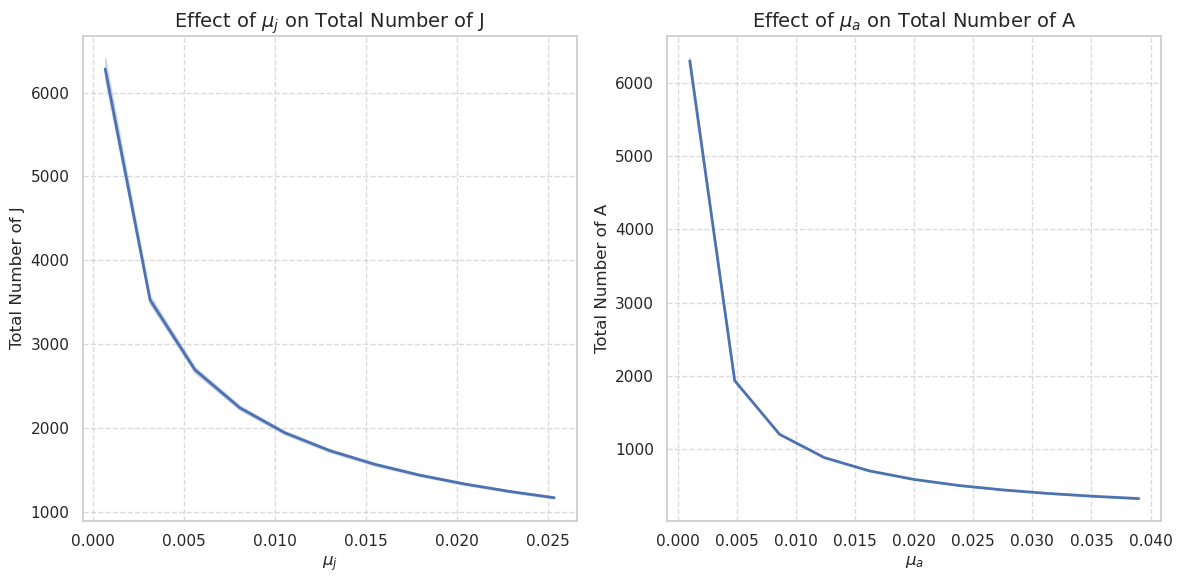

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the total number of J and A for each simulation
sensitivity_results_df['Total_J'] = (
    sensitivity_results_df['Sj']
    + sensitivity_results_df['Ij']
    + sensitivity_results_df['Cj']
    + sensitivity_results_df['Rj']
)
sensitivity_results_df['Total_A'] = (
    sensitivity_results_df['Sa']
    + sensitivity_results_df['Ia']
    + sensitivity_results_df['Ca']
    + sensitivity_results_df['Ra']
)

# Set seaborn style for improved aesthetics
sns.set(style="whitegrid")

# Create line plots to show how Total_J and Total_A change with mu_j and mu_a
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot for Total Number of J
sns.lineplot(x='mu_j', y='Total_J', data=sensitivity_results_df, ax=axes[0], linewidth=2)
axes[0].set_title('Effect of $\\mu_j$ on Total Number of J', fontsize=14)
axes[0].set_xlabel('$\\mu_j$', fontsize=12)
axes[0].set_ylabel('Total Number of J', fontsize=12)
axes[0].grid(True, linestyle='--', alpha=0.7)

# Plot for Total Number of A
sns.lineplot(x='mu_a', y='Total_A', data=sensitivity_results_df, ax=axes[1], linewidth=2)
axes[1].set_title('Effect of $\\mu_a$ on Total Number of A', fontsize=14)
axes[1].set_xlabel('$\\mu_a$', fontsize=12)
axes[1].set_ylabel('Total Number of A', fontsize=12)
axes[1].grid(True, linestyle='--', alpha=0.7)

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the plot
plt.savefig('effect_of_mu_on_totals_300dpi.pdf', dpi=300, bbox_inches='tight')

plt.show()


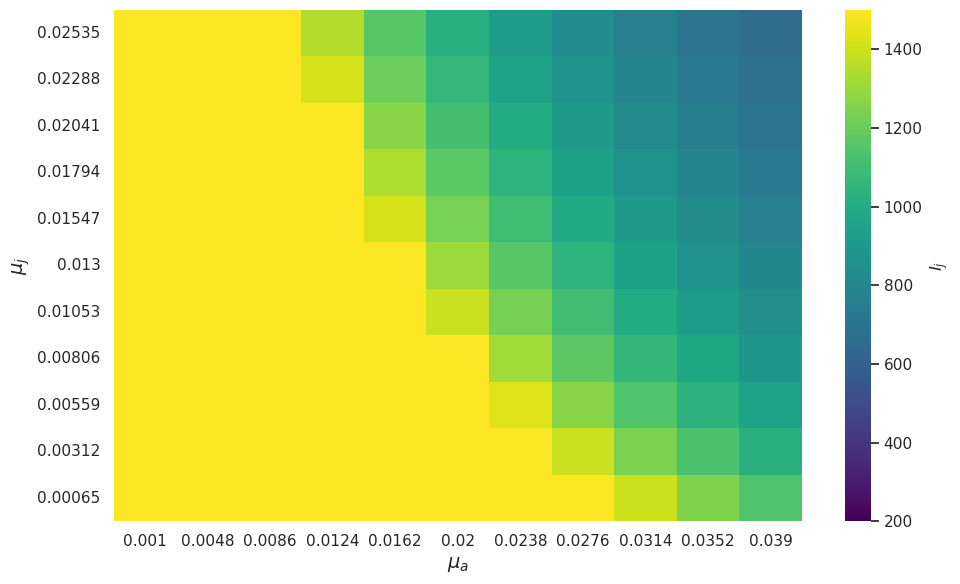

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns


# Choose the day
desired_day = 258  # For example, day 365

# Filter the sensitivity_results_df DataFrame for the desired day
desired_day_results = sensitivity_results_df[sensitivity_results_df['Time'] == desired_day]

# Set the desired color map value range
color_min = 200  # Minimum value for color map
color_max = 1500  # Maximum value for color map

# Set seaborn style for improved aesthetics
sns.set(style="whitegrid")

# Create a heatmap with fixed color map value range
fig, ax = plt.subplots(figsize=(10, 6))

heatmap_data = desired_day_results.pivot(index='mu_j', columns='mu_a', values='Ij')
# Round off all values to 4 decimal places
heatmap_data_rounded = heatmap_data.round(4)

# Round the index and column names to 4 decimal places
rounded_index = [round(idx, 5) for idx in heatmap_data.index]
rounded_columns = [round(col, 5) for col in heatmap_data.columns]

# Create a new DataFrame with rounded values, index, and columns
heatmap_data_rounded = pd.DataFrame(heatmap_data_rounded.values, index=rounded_index, columns=rounded_columns)

sns.heatmap(heatmap_data_rounded, cmap='viridis', annot=False, fmt=".4f", vmin=color_min, vmax=color_max, cbar_kws={'label': r'$I_j$'})

# Customize the plot
#plt.title(f"Phase Plot, Ij for Day {desired_day}", fontsize=16)
plt.xlabel(r"$\mu_a$", fontsize=14)
plt.ylabel(r"$\mu_j$", fontsize=14)

# Reverse the y-axis
ax.invert_yaxis()

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the plot
plt.savefig(f'phase_plot_Ij_day_{desired_day}_300dpi.pdf', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


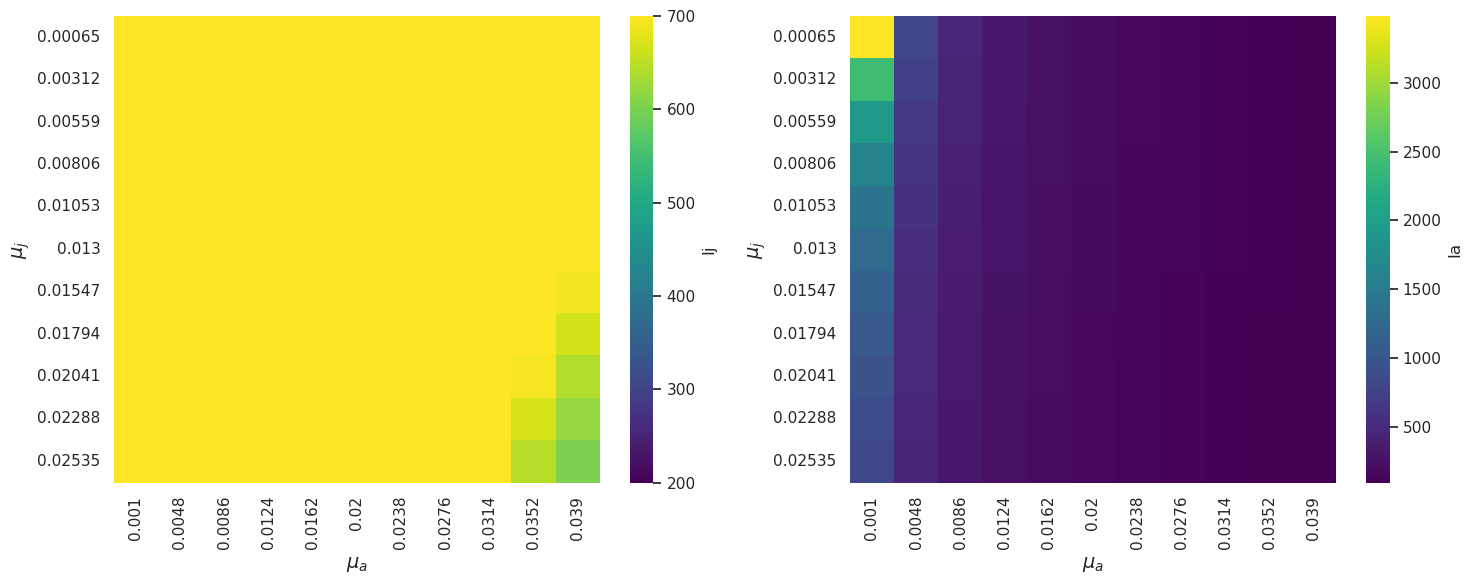

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Choose the day
desired_day = 249 #258 

# Filter the sensitivity_results_df DataFrame for the desired day
desired_day_results = sensitivity_results_df[sensitivity_results_df['Time'] == desired_day]

# Set the desired color map value range
color_min = 200  # Minimum value for color map
color_max = 700  # Maximum value for color map

# Set seaborn style for improved aesthetics
sns.set(style="whitegrid")

heatmap_data = desired_day_results.pivot(index='mu_j', columns='mu_a', values='Ij')
# Round off all values to 4 decimal places
heatmap_data_rounded = heatmap_data.round(4)

# Round the index and column names to 4 decimal places
rounded_index = [round(idx, 5) for idx in heatmap_data.index]
rounded_columns = [round(col, 5) for col in heatmap_data.columns]

# Create a new DataFrame with rounded values, index, and columns
heatmap_data_rounded = pd.DataFrame(heatmap_data_rounded.values, index=rounded_index, columns=rounded_columns)

# Extract 'Ia' values for the desired day
desired_day_results_Ia = sensitivity_results_df[sensitivity_results_df['Time'] == desired_day]
heatmap_data_Ia = desired_day_results_Ia.pivot(index='mu_j', columns='mu_a', values='Ia').round(4)

# Create a new DataFrame with rounded values, index, and columns for 'Ia'
heatmap_data_Ia_rounded = pd.DataFrame(heatmap_data_Ia.values, index=rounded_index, columns=rounded_columns)

# Create a new subplots for the second heatmap
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot the first heatmap for 'Ij'
sns.heatmap(heatmap_data_rounded, cmap='viridis', annot=False, fmt=".4f", vmin=color_min, vmax=color_max, cbar_kws={'label': 'Ij'}, ax=ax1)
#ax1.set_title(f"Ij for Day {desired_day}", fontsize=16)
ax1.set_xlabel("$\mu_a$", fontsize=14)
ax1.set_ylabel("$\mu_j$", fontsize=14)

# Plot the second heatmap for 'Ia'
sns.heatmap(heatmap_data_Ia_rounded, cmap='viridis', annot=False, fmt=".4f", cbar_kws={'label': 'Ia'}, ax=ax2)
#ax2.set_title(f"Ia for Day {desired_day}", fontsize=16)
ax2.set_xlabel("$\mu_a$", fontsize=14)
ax2.set_ylabel("$\mu_j$", fontsize=14)

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the combined plot
plt.savefig(f'combined_phase_plots_day_{desired_day}_300dpi.pdf', dpi=300, bbox_inches='tight')

# Show the combined plot
plt.show()


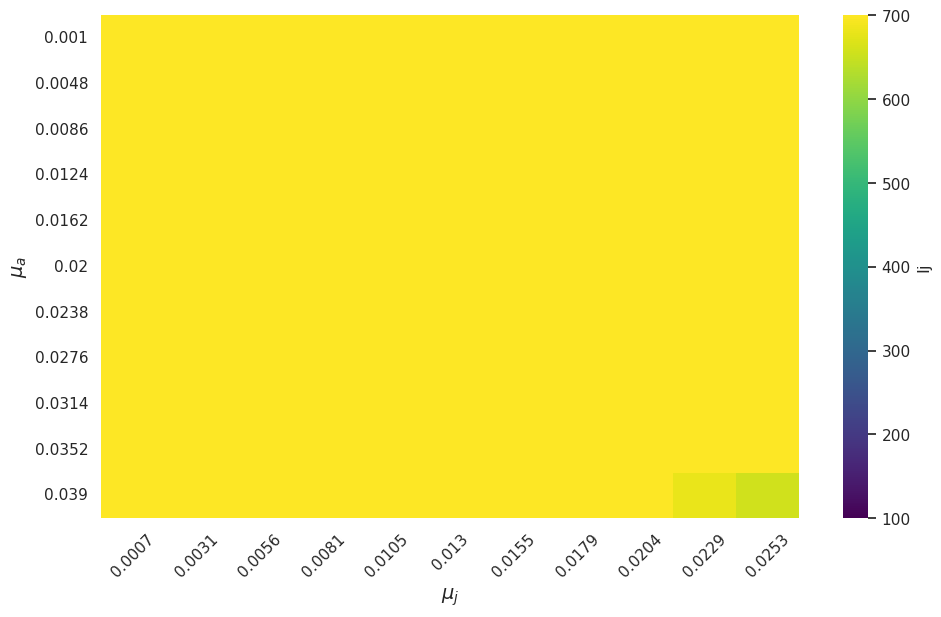

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Choose the day
desired_day = 258  # For example, day 365

# Filter the sensitivity_results_df DataFrame for the desired day
desired_day_results = sensitivity_results_df[sensitivity_results_df['Time'] == desired_day]

# Set the desired color map value range
color_min = 100  # Minimum value for color map
color_max = 700  # Maximum value for color map

# Set seaborn style for improved aesthetics
sns.set(style="whitegrid", rc={"grid.linestyle": "--"})

# Create a heatmap with fixed color map value range
fig, ax = plt.subplots(figsize=(10, 6))

heatmap_data = desired_day_results.pivot(index='mu_a', columns='mu_j', values='Ij')  # Interchanged mu_a and mu_j
# Round off all values to 4 decimal places
heatmap_data_rounded = heatmap_data.round(4)

# Round the index and column names to 4 decimal places
rounded_index = [round(idx, 4) for idx in heatmap_data.index]
rounded_columns = [round(col, 4) for col in heatmap_data.columns]

# Create a new DataFrame with rounded values, index, and columns
heatmap_data_rounded = pd.DataFrame(heatmap_data_rounded.values, index=rounded_index, columns=rounded_columns)

sns.heatmap(heatmap_data_rounded, cmap='viridis', annot=False, fmt=".3f", vmin=color_min, vmax=color_max, cbar_kws={'label': 'Ij'})

# Customize the plot
#plt.title(f"Phase Plot, Ij for Day {desired_day}", fontsize=16)
plt.xlabel("$\mu_j$", fontsize=14)  # Updated x-axis label
plt.ylabel("$\mu_a$", fontsize=14)  # Updated y-axis label

# Adjust layout to prevent overlap
plt.tight_layout()

# Rotate tick labels for better readability
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

# Save the plot
plt.savefig(f'phase_plot_Ij_day_{desired_day}_300dpi_mu_j-mu_a.pdf', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


In [29]:
import numpy as np

# Observed values
mu_j_obs = 0.15
mu_a_obs = 0.02

# Range percentage
range_pct = 0.5

# Number of values in each array
num_values = 11

# Create arrays with evenly spaced values
mu_j_values = np.linspace(mu_j_obs * (1 - range_pct), mu_j_obs * (1 + range_pct), num_values)
mu_a_values = np.linspace(mu_a_obs * (1 - range_pct), mu_a_obs * (1 + range_pct), num_values)

# Ensure the observed values are included in the arrays
mu_j_values[5] = mu_j_obs
mu_a_values[5] = mu_a_obs

print("mu_j_values:", mu_j_values)
print("mu_a_values:", mu_a_values)


mu_j_values: [0.075 0.09  0.105 0.12  0.135 0.15  0.165 0.18  0.195 0.21  0.225]
mu_a_values: [0.01  0.012 0.014 0.016 0.018 0.02  0.022 0.024 0.026 0.028 0.03 ]
